# Topic
1. What areas have the most influence on revenue?
2. How is a movie’s revenue and average score affected by its
genre?
3. What influence does release date have on revenue?

https://pythonspot.com/json-encoding-and-decoding-with-python/

## Import

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import scipy.stats as stats
import seaborn as sns
import re
from functools import reduce
import json
import sklearn.feature_selection

sns.set_style('whitegrid')
%matplotlib inline
sns.set()

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Load and View data

In [93]:
df = pd.read_csv('tmdb_5000_movies.csv', parse_dates=['release_date'])
df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
budget                  4803 non-null int64
genres                  4803 non-null object
homepage                1712 non-null object
id                      4803 non-null int64
keywords                4803 non-null object
original_language       4803 non-null object
original_title          4803 non-null object
overview                4800 non-null object
popularity              4803 non-null float64
production_companies    4803 non-null object
production_countries    4803 non-null object
release_date            4802 non-null datetime64[ns]
revenue                 4803 non-null int64
runtime                 4801 non-null float64
spoken_languages        4803 non-null object
status                  4803 non-null object
tagline                 3959 non-null object
title                   4803 non-null object
vote_average            4803 non-null float64
vote_count              4803 n

## Feature Engineering
* Extract the json from attribute `production_countries`
* Create dictionary `countries_revenue`: key is country and value is the list of movie revenue

In [95]:
countries_revenue = dict()
for label, row in df[['production_countries', 'revenue']].iterrows():
    json_load = '{"country": ' + row[0] + '}'
    data = json.loads(json_load)
    country_in_row = [element['name'] for element in data['country']]
    
    for country in country_in_row:
        if country in countries_revenue.keys():
            countries_revenue[country].append(row[1])
        else:
            countries_revenue[country]=[]
            countries_revenue[country].append(row[1])
            
#print(countries_revenue['United States of America'])

* Extract the json from attribute `genre`
* Create dictionary `genre_revenue`: key is genre and value is the list of movie revenue belonging to this genre
* Create dictionary `vote_average`: key is genre and value is the list of movie vote average belonging to this genre

In [96]:
genre_revenue = dict()
vote_revenue = dict()
for label, row in df[['genres', 'revenue', 'vote_average']].iterrows():
    genre_in_row = [sub[0: -2] for sub in re.findall('\w+\"\}', row[0])]
    for genre in genre_in_row:
        if genre in genre_revenue.keys():
            genre_revenue[genre].append(row[1])
            vote_revenue[genre].append(row[2])
        else:
            genre_revenue[genre] = []
            genre_revenue[genre].append(row[1])
            vote_revenue[genre] = []
            vote_revenue[genre].append(row[2])

* From `production_countries`, build DataFrame(country, revenue) to make boxplot
* From `genre_revenue`, `vote_average`, build DataFrame(genre, revenue, vote_average) to make boxplot

In [97]:
genre_array=[]
revenue_array=[]
vote_array=[]
countries_array=[]
countries_revenue_array=[]
for genre in genre_revenue.keys():
    genre_array.append([genre]*len(genre_revenue[genre]))
    revenue_array.append(genre_revenue[genre])
    vote_array.append(vote_revenue[genre])
    
for country in countries_revenue.keys():
    countries_array.append([country]* len(countries_revenue[country]))
    countries_revenue_array.append(countries_revenue[country])
    
genre_array = reduce(lambda x, y: x+y, genre_array)
revenue_array = reduce(lambda x, y: x+y, revenue_array)
vote_array = reduce(lambda x, y: x+y, vote_array)
countries_array = reduce(lambda x, y: x+y, countries_array)
countries_revenue_array = reduce(lambda x, y: x+y, countries_revenue_array)

genre_revenue_df = pd.DataFrame({
    'genre': genre_array,
    'revenue': revenue_array,
    'vote_average': vote_array
})

countries_revenue_df = pd.DataFrame({
    'country': countries_array,
    'revenue': countries_revenue_array
})
print(genre_revenue_df.head())
print(countries_revenue_df.head())

    genre     revenue  vote_average
0  Action  2787965087           7.2
1  Action   961000000           6.9
2  Action   880674609           6.3
3  Action  1084939099           7.6
4  Action   284139100           6.1
                    country     revenue
0  United States of America  2787965087
1  United States of America   961000000
2  United States of America   880674609
3  United States of America  1084939099
4  United States of America   284139100


## Question 1: What areas have the most influence on revenue?
* Null hypothesis: The revenue among the countries are not different
* Alternative hypothesis: The revenue among the countries are different

In [98]:
stats.f_oneway(countries_revenue['United States of America'], countries_revenue['United Kingdom'], countries_revenue['Jamaica'], countries_revenue['Bahamas'], countries_revenue['Dominica'])

F_onewayResult(statistic=11.992503796658534, pvalue=1.0734992849818085e-09)

* Get 4 countries for instance to test ANOVA, p-value $\approx 10^{-9}$. It is concluded that highly significant evidence against null hypothesis

Text(0.5,1,'The revenue among the countries')

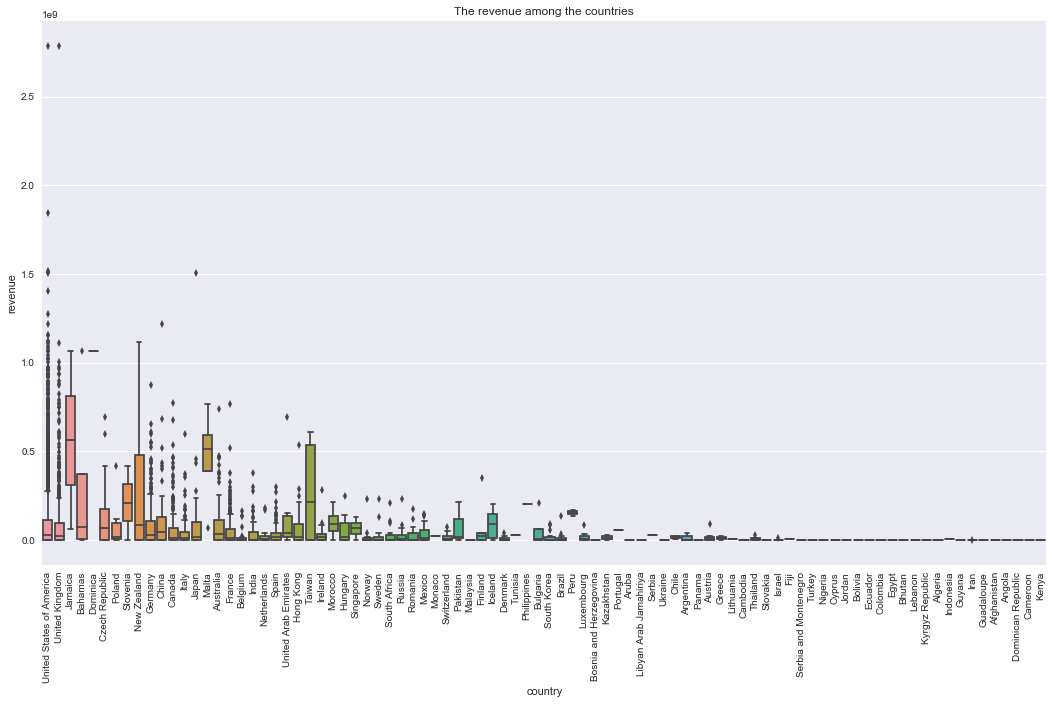

In [99]:
plt.figure(figsize=(18,10))
sns.boxplot(x='country', y='revenue', data=countries_revenue_df)
plt.xticks(rotation=90)
plt.title('The revenue among the countries')

* Although the mean of USA revenue is low, USA revenue boxplot has lots of outliers and many of them has very high revenue. Hence, USA has most influence on revenue

## Question 2: How is a movie’s revenue and average score affected by its genre?
### How is movie's revenue affected by its genre
* Null hypothesis: The revenue among the genres are not different
* Alternative hypothesis: The revenue among the genres are different

In [100]:
stats.f_oneway(genre_revenue['Action'], genre_revenue['Adventure'], genre_revenue['Fantasy'], genre_revenue['Fiction'])

F_onewayResult(statistic=12.49752164445699, pvalue=4.056663218822023e-08)

* Get 4 genres for instance to test ANOVA, p-value $\approx 4.10^{-8}$. It is concluded that highly significant evidence against null hypothesis

Text(0.5,1,'The revenue among the genres')

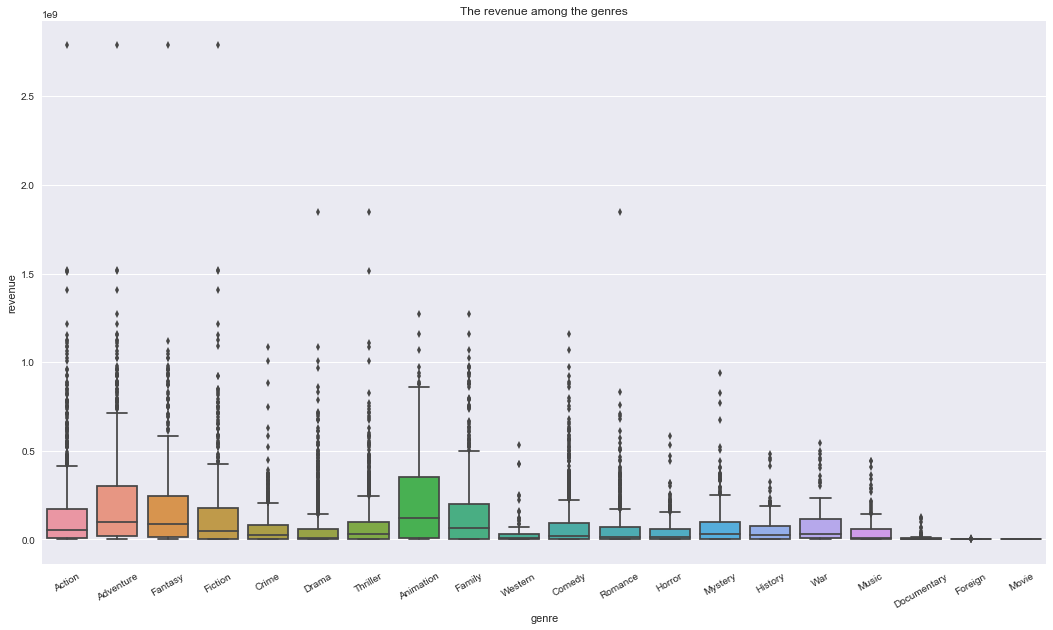

In [101]:
plt.figure(figsize=(18,10))
sns.boxplot(x='genre', y='revenue', data=genre_revenue_df)
plt.xticks(rotation=30)
plt.title('The revenue among the genres')

* Based on box plot, **Action** and **Adventure** has the high average revenue and their revenue boxplot also has lots of outliers, many of them has the high revenue

### How is vote average's revenue affected by its genre
* Null hypothesis: The vote average among the genres are not different
* Alternative hypothesis: The vote average among the genres are different

In [102]:
stats.f_oneway(vote_revenue['Action'], vote_revenue['Adventure'], vote_revenue['Fantasy'], vote_revenue['Fiction'])

F_onewayResult(statistic=5.226047921084505, pvalue=0.0013447950215057923)

* Get 4 genres for instance to test ANOVA, p-value $\approx 0.0013$. It is concluded that highly significant evidence against null hypothesis

Text(0.5,1,'Vote average among the genres')

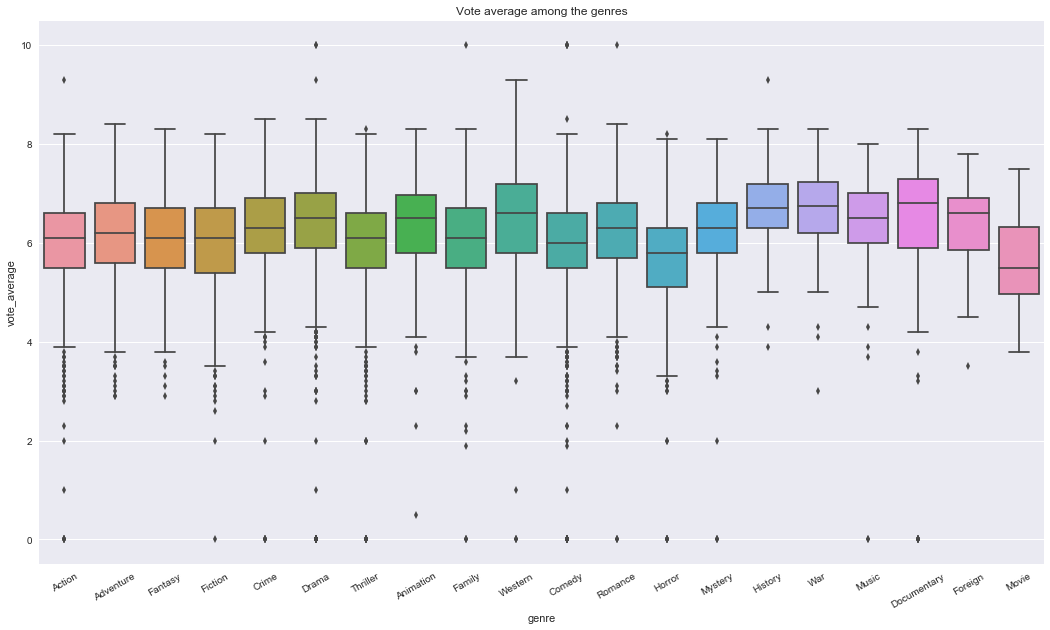

In [103]:
plt.figure(figsize=(18,10))
sns.boxplot(x='genre', y='vote_average', data=genre_revenue_df)
plt.xticks(rotation=30)
plt.title('Vote average among the genres')

* Based on box plot, **Drama** has the high average vote and its boxplot also has some outliers which are highest vote average

## Question 3: What influence does release date have on revenue?
* Extract `month` and `day` from `release_date` to make new column `datetime`

In [104]:
df.drop([4553], inplace=True)
df['datetime'] = list(df['release_date'].map(lambda x: x.strftime('%m-%d')))
df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,datetime
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,12-10
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,05-19
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,10-26
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,07-16
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,03-07


* Create dataframe `df_datetime`: Total revenue of all year in the same day

In [105]:
month_day = {1: 31, 2: 28, 3: 31, 4: 30, 5: 31, 6: 30, 7: 31, 8: 30, 9: 31, 10: 30, 11: 31, 12: 31}
datetime_revenue = dict()
for label, row in df[['revenue', 'datetime']].iterrows():
    if row[1] in datetime_revenue.keys():
        datetime_revenue[row[1]] = datetime_revenue[row[1]] + row[0]
    else:
        datetime_revenue[row[1]] = row[0]

df_datetime = pd.DataFrame({
    'Date': list(datetime_revenue.keys()),
    'Revenue': list(datetime_revenue.values())
})
df_datetime.sort_values(['Date'], inplace=True)
df_datetime.head()

,Date,Revenue
332,01-01,264769918
357,01-03,47241945
302,01-04,6416302
355,01-05,51508261
347,01-06,343564587


Text(0.5,1,'Total revenue of all year')

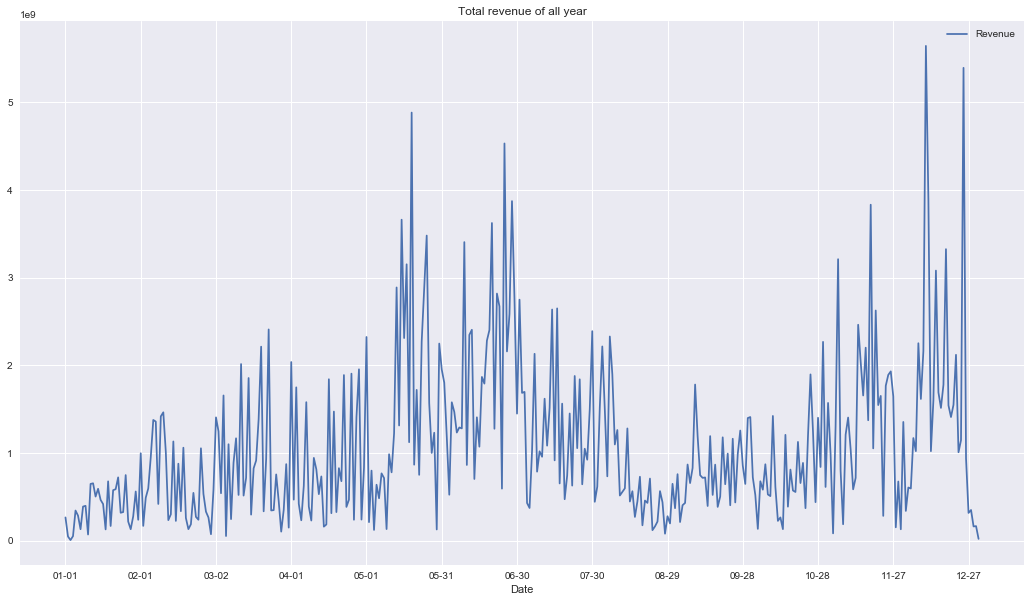

In [106]:
plt.figure(figsize=(18, 10))
plt.xticks([i for i in range(0, 390, 30)])
df_datetime.plot(x='Date', y='Revenue', ax = plt.gca())
plt.title('Total revenue of all year')

* Conclusion: there are 2 periods in the year that revenue increase substantially: **From mid May to June** and **last 3 month**
* The first one has Memorial Day and Independence Day which US citizens take day off.
* The second one is in Winter holiday